# Previsão de vendas utilizando series temporais.

Nesse projeto vamos previsão da receita final em 10 semanas de vendas de uma loja de departamentos que esta localizada na Russia, com diferentes lojas espalhadas pelo pais, além disso vendendo produtos online. 

No conjunto de dados temos informações do produto quando foi vendido, o shop em que foi vendido,a quantidade de itens comprado, o nome e o id do item, além disso existe uma variavel que faz a contagem consecutiva dos valores dos meses que passa. As variaveis são:

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

Nesse trabalho estamos lidando um problema de series temporais, foi utilizado a abordagem diaria para se calcular os valores preditos, porém poderia ter feito para a soma mensal ou anual. Nosso conjunto de dados consta 2 milhoes de vendas e vamos criar um modelo para prever as vendas futura.

O conjunto de dados foi retirado do kaggle.

# 0 - Iniciando

Importanto os pacotes e foi feito duas funções que vão servir na hora de fazer a avaliação do modelo, vamos utilizar três metricas para avaliar nossos modelos, a primeira vai ser o erro medio absoluto ( mean absolute error - MAE), o segundo é o erro percentual medio absoluto (Mean absolute percentage error - MAPE ) e por fim Erro quadratico medio (Root-mean-square error - RMSE).

## 0.0 - Importando os dados e pacotes

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import datetime

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

import pickle

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler


from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from googletrans import Translator

import pandas.util.testing as tm
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
df_itens = pd.read_csv('items.csv')
df_sales1 = pd.read_csv('sales_train.csv')

df_sales_raw = pd.merge(df_sales1,df_itens, how = 'left',on = 'item_id')

## 0.1 Funções utilizadas

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs(( np.array(y) - np.array(yhat)) / np.array(y)))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame( {'Model Name':model_name,
                          'MAE' : mae,
                          'MAPE':mape,
                          'RMSE':rmse}, index = [0])

def cross_val(x_training,kfold, model_name,model,verbose = False):

    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('Kfold Number: {} \n'.format(k))
        #start and end date f0r validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_start_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[(x_training['date'] >=  validation_start_date) &  (x_training['date'] <=  validation_start_end_date)]

        #training and validation dataset
        xtraining = training.drop(['date','revenue'],axis = 1)
        ytraining = training['revenue']

        xvalidation = validation.drop(['date','revenue'],axis = 1)
        yvalidation = validation['revenue']

        #model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat_m = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation),np.expm1(yhat_m))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name':model_name,
                         'MAE CV': np.round( np.mean( mae_list),2).astype(str) + ' +/- ' + np.round( np.std( mae_list),2).astype(str),
                         'MAPE CV':np.round( np.mean( mape_list),2).astype(str) + ' +/- ' + np.round( np.std( mape_list),2).astype(str),
                         'RMSE CV':np.round( np.mean( rmse_list),2).astype(str) + ' +/- ' + np.round( np.std( rmse_list),2).astype(str)},index=[0])


# 1.0 Descrição dos dados

Nessa seção vamos fazer uma descrição dos dados, vamos juntar conjuntos de dados que estão em diferentes tabelas, mudar o tipo dos dados, ver se tem algum valor faltante, fazer uma estatistica descritiva dos dados e fazer a correção de outliers.

In [27]:
df1 = df_sales_raw.copy()
df1.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
2408982,06.01.2015,24,54,8469,349.000000,1.0,Акунин Борис История Российского Гос-ва Бох ...,43
1564863,14.04.2014,15,25,1916,248.833333,3.0,Bestseller. Sid Meier's Civilization V. Золото...,30
405280,23.04.2013,3,58,5433,299.000000,1.0,PARAMORE Paramore,55
2813814,30.08.2015,31,3,10131,229.000000,1.0,ВЫСОЦКИЙ ВЛАДИМИР Grand Collection Лучшее дл...,55
2607523,05.04.2015,27,14,3236,2398.000000,1.0,"Evil Within [PS3, русские субтитры]",19


In [34]:
shops = pd.read_csv('shops.csv')
city_names = []

translator = Translator()
#print(translator.translate( 'Ярославль', dest = 'en').text)

for city in shops['shop_name'].values:
    aux = city.split()[0]
    city_names.append(translator.translate(aux, dest = 'en').text)
city_names[55] = 'Online store'

shops['shop_name'] = city_names

In [35]:
df1 =  pd.merge(df1,shops, how = 'left',on = 'shop_id')

## 1.1 Nomes das colunas

In [7]:
df1.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id'],
      dtype='object')

## 1.2 Dimensão dos dados

In [6]:
print('Number of Rows {}'.format(df1.shape[0]))
print('Number of Cols {}'.format(df1.shape[1]))

Number of Rows 2935849
Number of Cols 8


In [7]:
df1.shape[0]

2935849

## 1.3 Data types

In [8]:
df1.dtypes

date                 object
date_block_num        int64
shop_id               int64
item_id               int64
item_price          float64
item_cnt_day        float64
item_name            object
item_category_id      int64
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Missing values

In [10]:
df1.isna().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_name           0
item_category_id    0
dtype: int64

In [11]:
df1.drop(df1[df1['item_price'].isna()].index,inplace = True)

In [12]:
df1['item_cnt_day'] = df1['item_cnt_day'].astype(int)

## 1.5 Descriptive Statistical

In [13]:
 numerical_columns = df1.select_dtypes(include = ['int64','float'])

In [14]:
mean = pd.DataFrame(numerical_columns.apply(np.mean )).T
median = pd.DataFrame(numerical_columns.apply(np.median )).T

std = pd.DataFrame(numerical_columns.apply(np.std )).T
minin = pd.DataFrame(numerical_columns.apply(lambda x: x.min() )).T
maxam = pd.DataFrame(numerical_columns.apply(lambda x: x.max() )).T
amp = pd.DataFrame(numerical_columns.apply(lambda x: x.max()-x.min())).T

skew = pd.DataFrame(numerical_columns.apply(lambda x: x.skew())).T
kurt = pd.DataFrame(numerical_columns.apply(lambda x: x.kurtosis())).T

In [15]:
Desc = pd.concat([mean,median,std,minin,maxam,amp,skew,kurt]).T.reset_index()

Desc.columns = ['Atribute','mean','median','std','min','max','amplitude','skew','kurtosis']

Desc

,Atribute,mean,median,std,min,max,amplitude,skew,kurtosis
0,date_block_num,14.569911,14.0,9.422986,0.0,33.0,33.0,0.203858,-1.082869
1,shop_id,33.001728,31.0,16.226970,0.0,59.0,59.0,-0.072361,-1.025358
2,item_id,10197.227057,9343.0,6324.296277,0.0,22169.0,22169.0,0.257174,-1.225210
3,item_price,890.853233,399.0,1729.799336,-1.0,307980.0,307981.0,10.750423,445.532826
4,item_category_id,40.001383,40.0,17.100756,0.0,83.0,83.0,0.318283,-0.525158


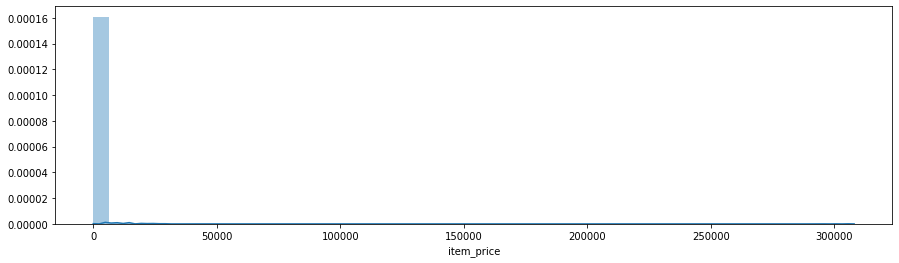

In [16]:
plt.figure(figsize=(15,4))
sns.distplot(df1['item_cnt_day'])

## 1.6 Arrumandos Dados negativos

In [17]:
index_neg_price = df1[df1['item_price'] < 0].index

In [18]:
game_2973 = df1[(df1['date'] == '15.05.2013')].query('item_id == 2973')
price_2973 = game_2973['item_price'].unique().max()
df1['item_price'].iloc[index_neg_price] = price_2973

item_cnt_day é a quantidade de produtos que foram vendidos naquele dia, quando negativo na minha opinião pode estar relacionado quando o produto é devolvido naquele dia. Nesse caso como temos poucos valores, vou retirar do conjunto de dados.

In [21]:
index_neg_quantity = df1[df1['item_cnt_day'] < 0].index

In [22]:
df1.drop(index_neg_quantity, inplace = True)

## 1.7 Tratando Outliers

In [23]:
#sns.boxplot(df1['item_price'])
sales_out = df1[df1['item_price'] > 40000].index
df1 = df1.drop(sales_out)

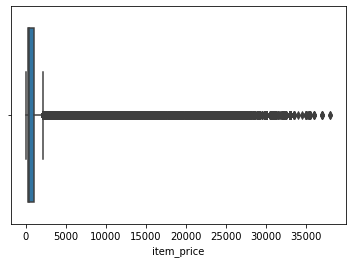

In [24]:
sns.boxplot(df1['item_price'])

In [25]:
item_cnt_day_out = df1[df1['item_cnt_day'] > 400].index
df1 = df1.drop(item_cnt_day_out)

# 2.0 Feature Engineering

Nesse capitulo criamos as possiveis hipoteses que podem estar relacionado com a empresa vendendo produtos, com isso dividindo em clientes, produtos, lojas e tempo. Selecionamos as hipoteses possiveis de ser respondidas pelo nosso conjuntos de dados.

Além disso foi feito a criação de variaveis que estão relacionadas com as nossas variaveis originais, por exemplo separamos a data de compra do produto e criamos o dia, mês e ano, além de criamos qual dia da semana esta e qual semana do ano aconteceu. Como temos diferente lojas, criamos a idade da loja, onde foi feito a diferente entre a primeira e a sua ultima compra.

Como estamos trabalhando com series temporal, existe uma sazionalidade das compras, para que o modelo entenda essa sazionalidade, criamos a coluna com o valor sem essa sazionalidade (retirando os valores do mesmo dia no ano passado). Assim como criamos a variavel lag que esta relacionado a diferença entre a compra em um dia com o dia anterior.

## 2.1 Lista de Hipoteses

In [26]:
df2 = df1.copy()

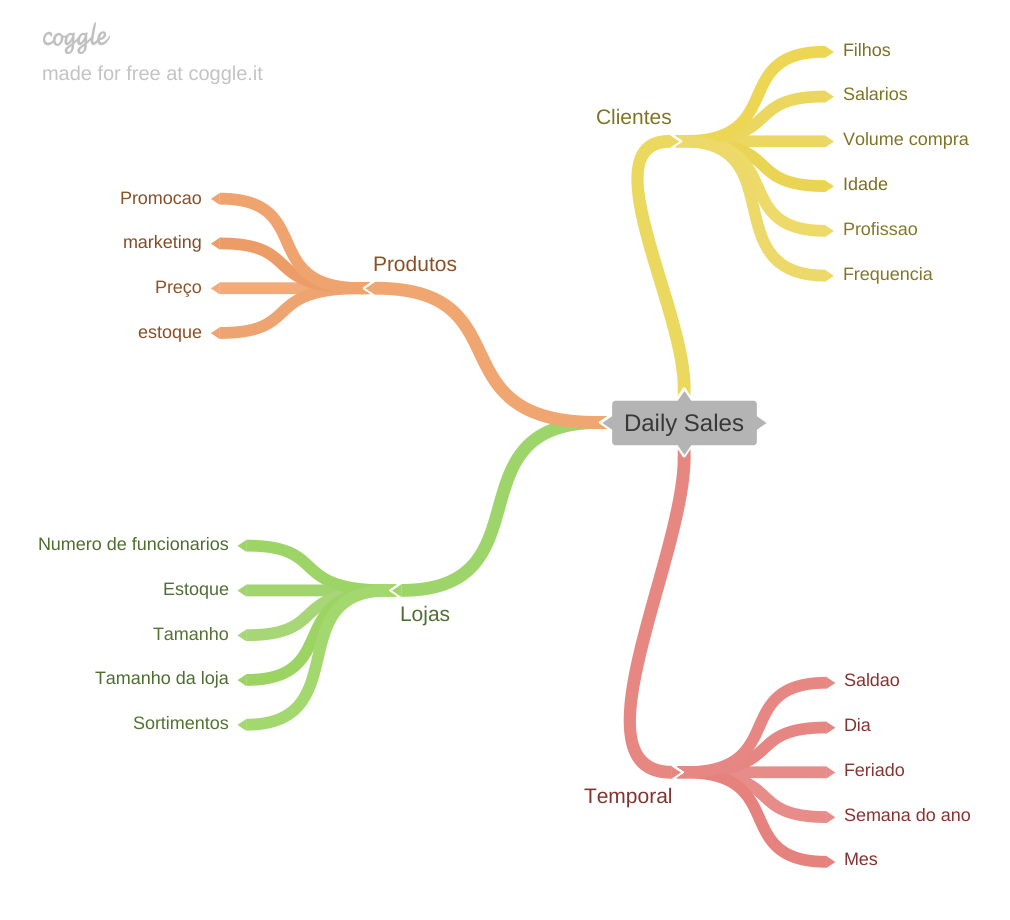

In [63]:
Image('img/Daily_Sales.png')

### 2.1.1 Produtos

**1. Lojas que investem mais em marketing deveriam vender mais**

**2. Lojas  com maior exposição de produtos deveriam vender mais**

**3. Lojas com produtos com preço menor deveriam vender mais**

**4. LOjas com promoções mais agressivos, deveriam vender mais**

### 2.1.2 Lojas

**1. Lojas com numero maior de funcionarios deveriam vender mais**

**2. Lojas com maior capacidade de estoque deveriam vender mais**

**3. Lojas com maior porte deveriam vender mais**

**4. Lojas com maior sortimento deveriam vender mais**

**5. Lojas em cidades maiores vendem mais**

### 2.1.3 Temporal

**1. Lojas Abertas durante feriados deveriam menos**

**2. Lojas deveriam vender mais ao longo dos anos**

**3. Lojas deveriam vender mais no segundo semestre**

**4. Lojas deveriam vender mais depois do quinto dia util de cada mês**

**5. Lojas deveriam vender menos aos finais de semana**

**6. Lojas deveriam vender mais no natal**

## 2.2 Lista Final de Hipóteses


**1. Lojas com diferentes categorias de produtos deveriam vender mais**

**2. Lojas deveriam vender mais ao longo dos anos**

**3. Lojas deveriam vender mais no segundo semestre do ano**

**4. Lojas deveriam vender mais depois do quinto dia util**

**5. Lojas deveriam vender menos aos finais de semana**

**6. Lojas mais velhas devem vender mais**

**7. Lojas em cidades grandes vendem mais**

## 2.3 Feature Engineering

In [70]:
#year - month - week of year - year week
df2['year'] = df2['date'].dt.year

df2['month'] = df2['date'].dt.month

df2['day'] = df2['date'].dt.day

df2['week_of_year'] = df2['date'].dt.weekofyear

df2['day_of_week'] = df2['date'].dt.dayofweek

df2['year_week'] =df2['date'].dt.strftime('%Y-%W')

In [71]:
shop_id_min = min(df2['shop_id'])
shop_id_max = max(df2['shop_id'])

age_shop = []


for i in range(int(shop_id_min),(int(shop_id_max)+1)):

    a = df2[df2['shop_id'] == i].date.min()
    b = df2[df2['shop_id'] == i].date.max()
    dif = b - a
    age_shop.append(round((dif.days)/(12*30),2))

df2['age_shop'] = df2['shop_id'].apply(lambda x: age_shop[int(x)])

In [6]:
#Criando o valor total da venda naquele dia
df2['revenue'] = df2['item_price'].values * df2['item_cnt_day'].values


In [148]:
first_part = list(range(0,12))
second_part = list(range(12,24))
third_part = list(range(24,36))

lists = []
for i in range(0,len(df2)):
    if df2.iloc[i]['year'] == 2013:
        time = first_part
        lists.append(time[df2.iloc[i]['month'] - 1])
    elif df2.iloc[i]['year'] == 2014:
        time = second_part
        lists.append(time[df2.iloc[i]['month'] - 1])
    elif df2.iloc[i]['year'] == 2015:
        time = third_part
        lists.append(time[df2.iloc[i]['month'] - 1])
        
df2['date_block_num'] = lists

In [177]:
df2['Diff_sazon'] = 0
df2['Lag_1'] = 0

for shop in df2['shop_id'].unique():
    aux1 = df2[df2['shop_id'] == shop]
    aux2 = aux1[['date','revenue']].groupby('date').median().reset_index()

    for i in range(0,len(aux2)):
        #print(i)
        dates = aux1[aux1['date'] == aux2['date'][i]]
        if len(aux2) > 360:
            diff = dates['revenue'].values - aux2['revenue'].values[i - 360]
        else:
             diff = dates['revenue'].values - aux2['revenue'].values[i]
        indexs = df2[(df2['shop_id'] == shop) & (df2['date'] == aux2['date'][i])].index
        df2.iloc[indexs,df2.shape[1]-1] = diff
        
    for i in range(1,len(aux2)):
        dates = aux1[aux1['date'] == aux2['date'][i]]
        diff_lag = dates['revenue'].values - aux2['revenue'][i-1]
        
        indexs = df2[(df2['shop_id'] == shop) & (df2['date'] == aux2['date'][i])].index
        df2.iloc[indexs,df2.shape[1]-2] = diff_lag


59
25
24
23
19
22
18
21
28
27
29
26
4
6
2
3
7
0
1
16
15
8
10
14
13
12
53
31
30
32
35
56
54
47
50
42
43
52
51
41
38
44
37
46
45
5
57
58
55
17
9
49
39
40
48
34
33
20
11
36


# 3.0 Filtragem de variaveis

Foi feito a filtragem das variaveis, tentando focar nas variaveis que são possiveis ter em mãos na hora de usar o modelo, por exemplo não é possivel saber quantos itens vão ser vendidos em um certo periodo (é possivel criar um outro modelo de machine learning para realizar essa predição).

In [5]:
df3 = df2.copy()

df3 = df3[df3['item_price'] < 100000]
df3 = df3.drop(df3[df3['revenue'] > 750000].index)

## 3.1 Selecao das Colunas

In [6]:
#item_cnt_day
columns_drops = ['item_cnt_day','item_name','item_price']

df3 = df3.drop(columns_drops,axis = 1)

# 4.0 Analise Exploratorio de Dados

Nessa seção vamos fazer uma análise mais detalhada sobre os nossos dados, dividindo inicialmente pelas variaveis separadas, depois uma análise de duas em duas variaveis e por fim a correlação entre elas.

Também respondemos as hipoteses criadas na seção 2, mostrando quais podem gerar algum insight para nosso problema.

In [7]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

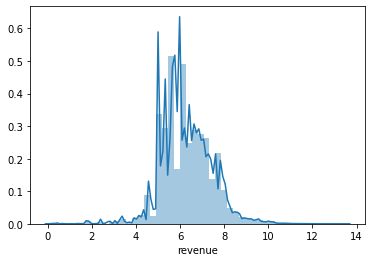

In [8]:
sns.distplot(np.log1p(df4['revenue']))

### 4.1.2 Numerical Variable

In [9]:
 numerical_columns = df4.select_dtypes(include = ['int64','float'])

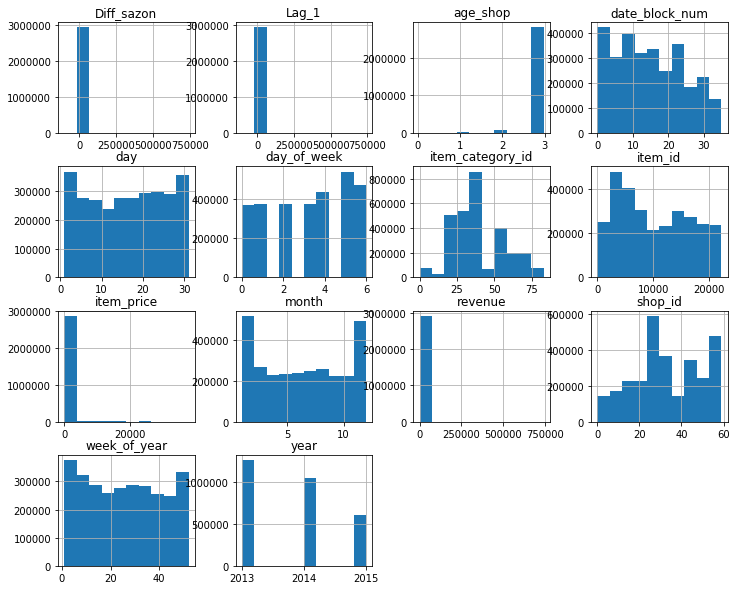

In [9]:
numerical_columns.hist(figsize = (12,10));

## 4.2 Analise Bivariada

### **1. Lojas com diferentes categorias de produtos deveriam vender mais**

Não é totalmente falso, vemos que as lojas com maiores vendas são aquelas que vendem mais produtos, e com as menores vendas são que vendem menos tipos de produtos, porém as demais lojas com mais de 50 tipos de produtos ficam acimas das demais porém longe dos valores das maiores vendas.

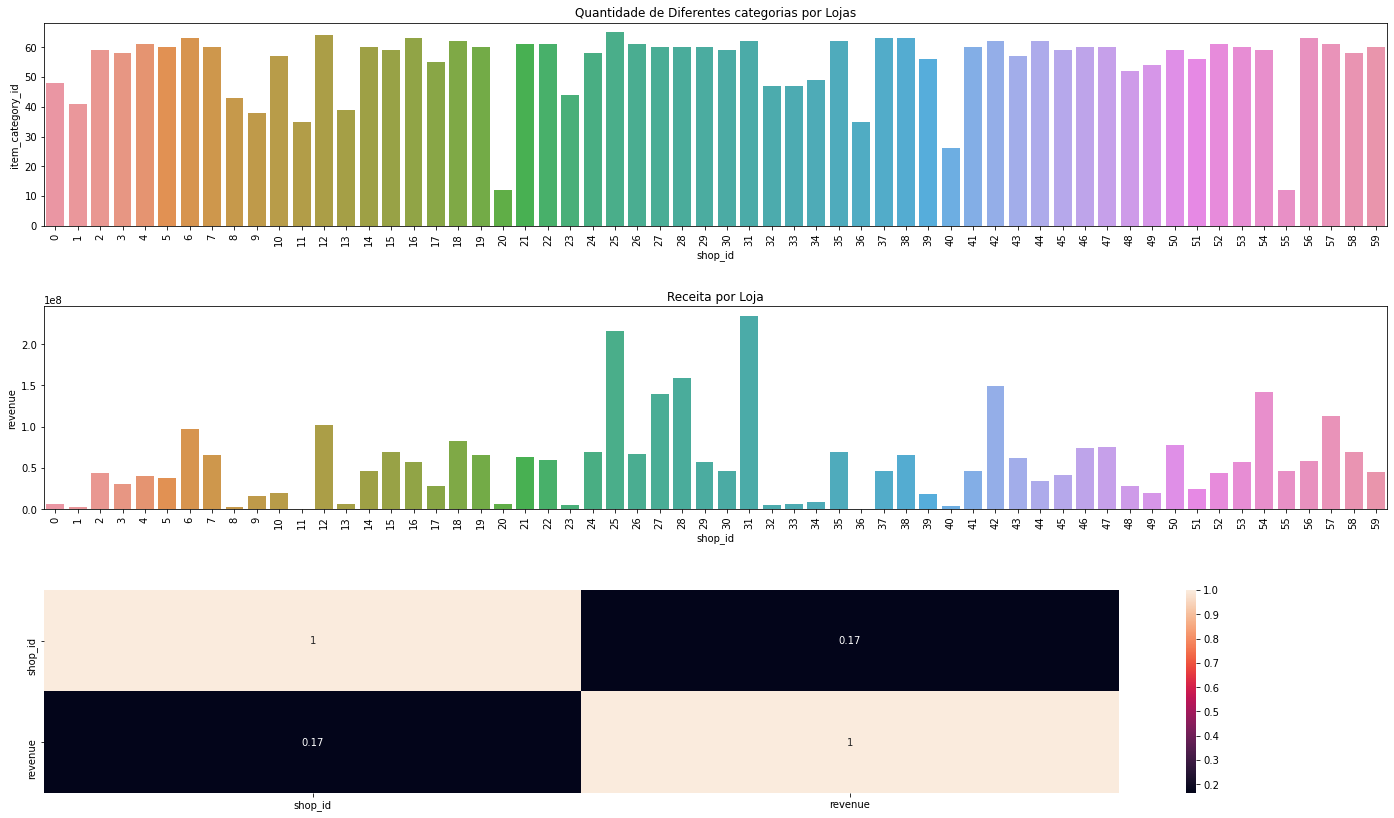

In [13]:
plt.figure(figsize=(20,12))


plt.subplot(3,1,1)
aux2 = df4[['shop_id','item_category_id']].groupby(['shop_id','item_category_id']).count().reset_index()
aux3 = aux2.groupby('shop_id').count().reset_index()

sns.barplot(x = 'shop_id',y = 'item_category_id', data = aux3);
plt.xticks(rotation = 90);
plt.title('Quantidade de Diferentes categorias por Lojas')

plt.subplot(3,1,2)
#aux1 = df4[['shop_id','item_price','item_category_id']].groupby('shop_id').sum().reset_index()
aux1 = df4[['shop_id','revenue','item_category_id']].groupby('shop_id').sum().reset_index()

sns.barplot(x = 'shop_id',y = 'revenue', data = aux1);
plt.xticks(rotation = 90);
plt.title('Receita por Loja')

plt.subplot(3,1,3)
aux4 = df4[['shop_id','revenue']].groupby('shop_id').sum().reset_index()
sns.heatmap(aux4.corr(method = 'pearson'), annot = True);

plt.tight_layout(pad=3.0)

### **2. Lojas deveriam vender mais ao longo dos anos**
**Falsa** Lojas vendem menos ao longo dos anos.

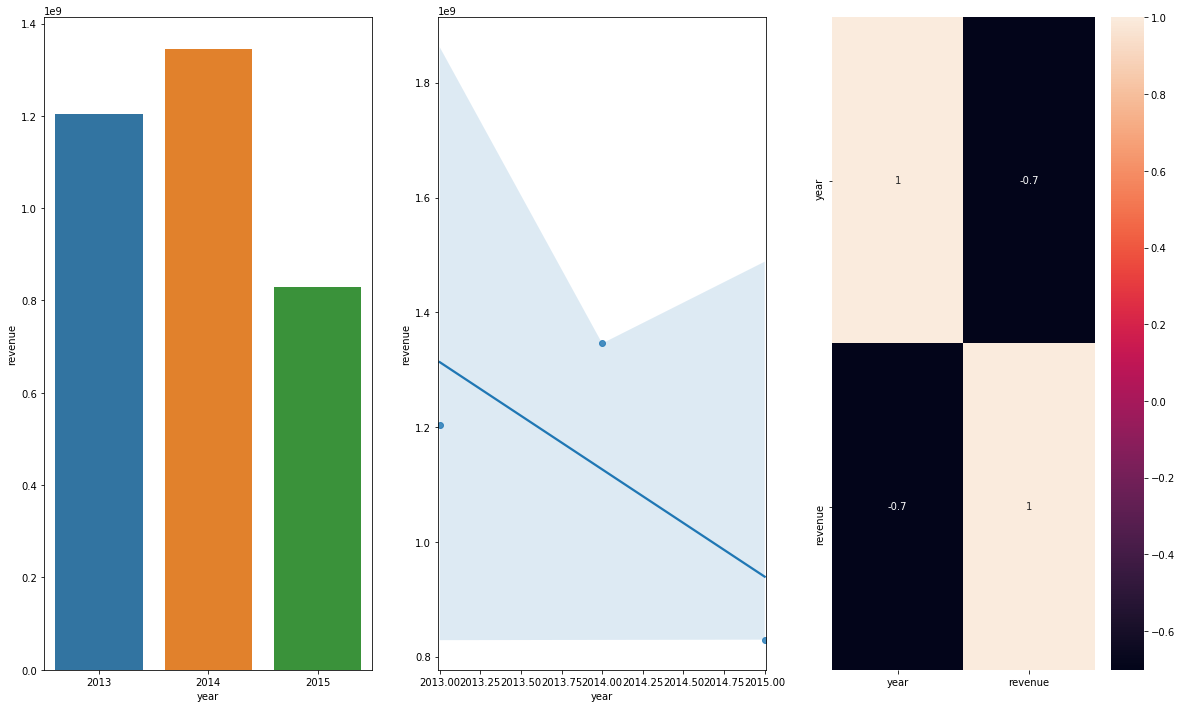

In [11]:
aux2 = df4[['year','revenue']].groupby('year').sum().reset_index()

plt.figure(figsize=(20,12))

plt.subplot(1,3,1)
sns.barplot(x = 'year',y = 'revenue', data = aux2);

plt.subplot(1,3,2)
sns.regplot(x = 'year',y = 'revenue', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method= 'pearson'),annot = True);

### **3. Lojas deveriam vender mais no segundo semestre do ano**
**Verdadeiro**  Na Soma total podemos perceber que vendem mais no segundo semestre, porém dezembro que tem maior carga.

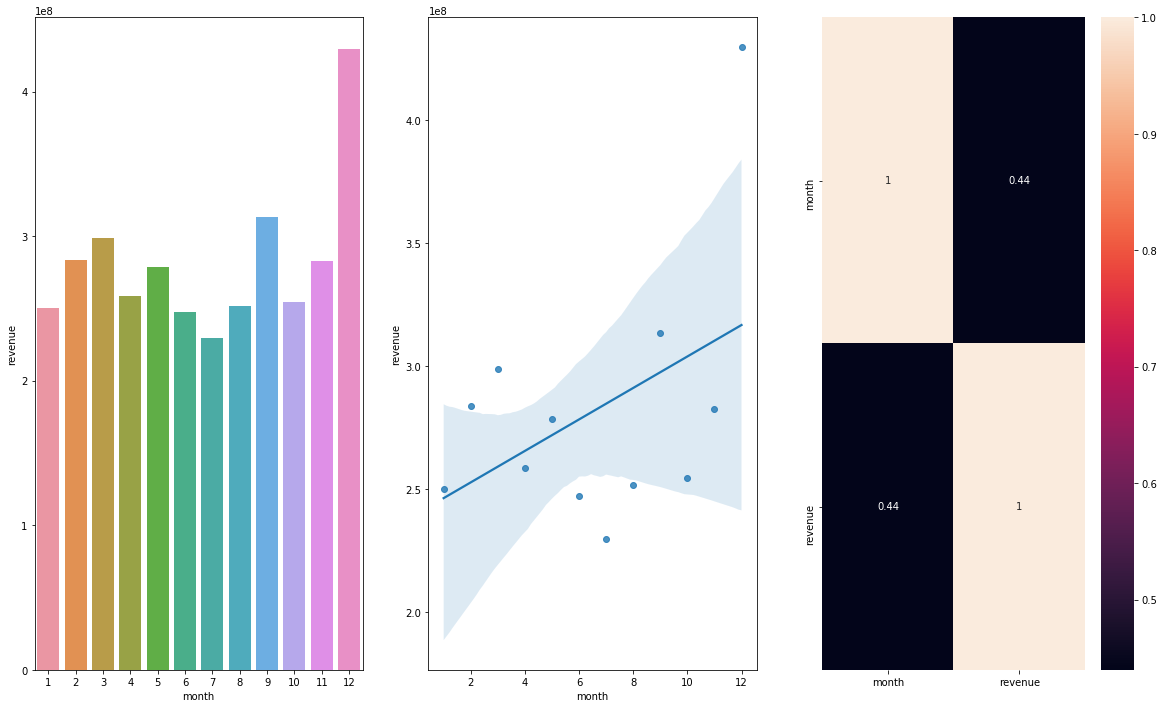

In [12]:
aux2 = df4[['month','revenue']].groupby('month').sum().reset_index()

plt.figure(figsize=(20,12))

plt.subplot(1,3,1)
sns.barplot(x = 'month',y = 'revenue', data = aux2);

plt.subplot(1,3,2)
sns.regplot(x = 'month',y = 'revenue', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method= 'pearson'),annot = True);

### **4. Lojas deveriam vender após o dia 10 de cada mes**

**Verdadeiro**

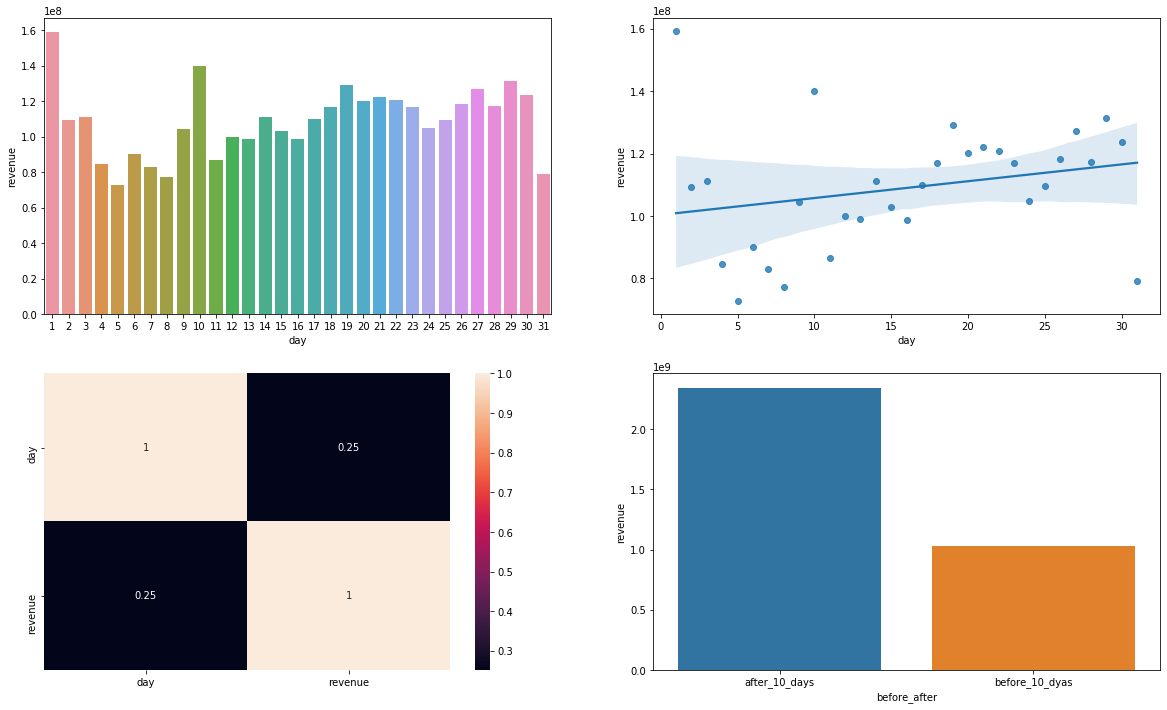

In [13]:
aux2 = df4[['day','revenue']].groupby('day').sum().reset_index()

plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.barplot(x = 'day',y = 'revenue', data = aux2);

plt.subplot(2,2,2)
sns.regplot(x = 'day',y = 'revenue', data = aux2);

plt.subplot(2,2,3)
sns.heatmap(aux2.corr(method= 'pearson'),annot = True);

aux2['before_after'] = aux2['day'].apply(lambda x: 'before_10_dyas' if x <= 10 else 'after_10_days')
aux3 = aux2[['before_after','revenue']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after',y = 'revenue', data = aux3)

### **5. Lojas deveriam vender menos aos finais de semana**

**Falso** As lojas vendem mais durantes os finais de semana

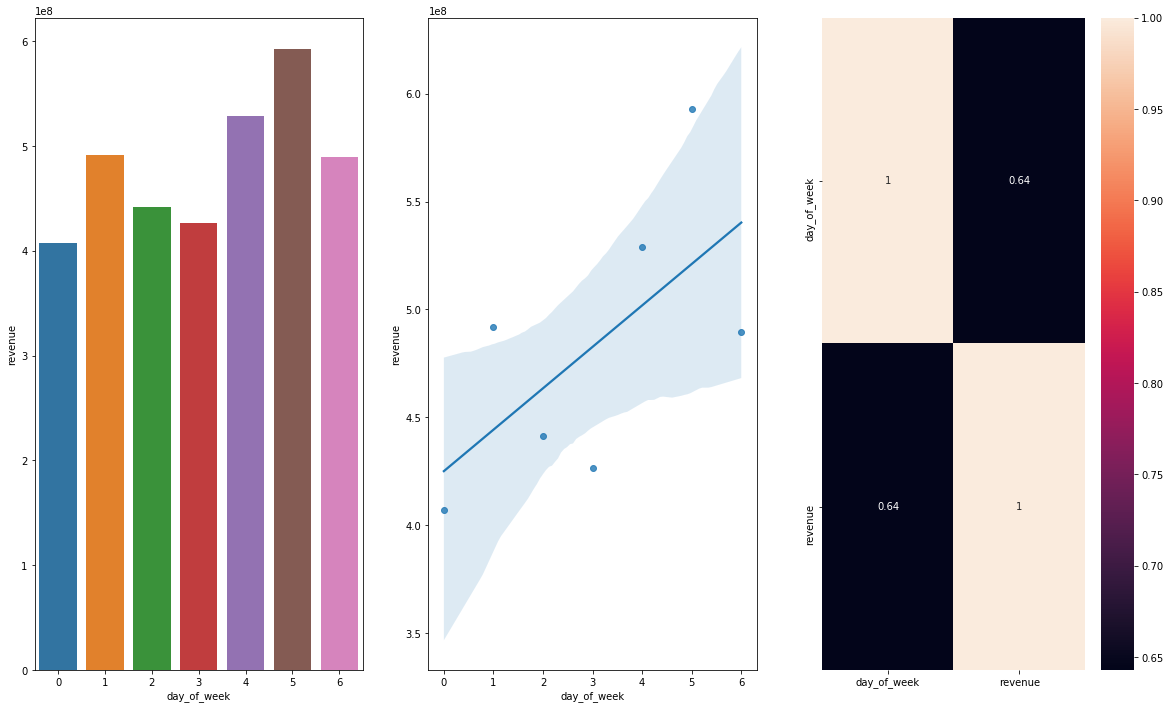

In [14]:
aux2 = df4[['day_of_week','revenue']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20,12))

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week',y = 'revenue', data = aux2);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week',y = 'revenue', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method= 'pearson'),annot = True);

### **6. Lojas mais velhas devem vender mais pela média**

**Falsa** - É falsa, pois se utilizarmosa a soma total, como tem lojas com mais tempo teriam mais
produtos vendidos, porém quando usamos a media notamos que não segue o mesmo padrão.

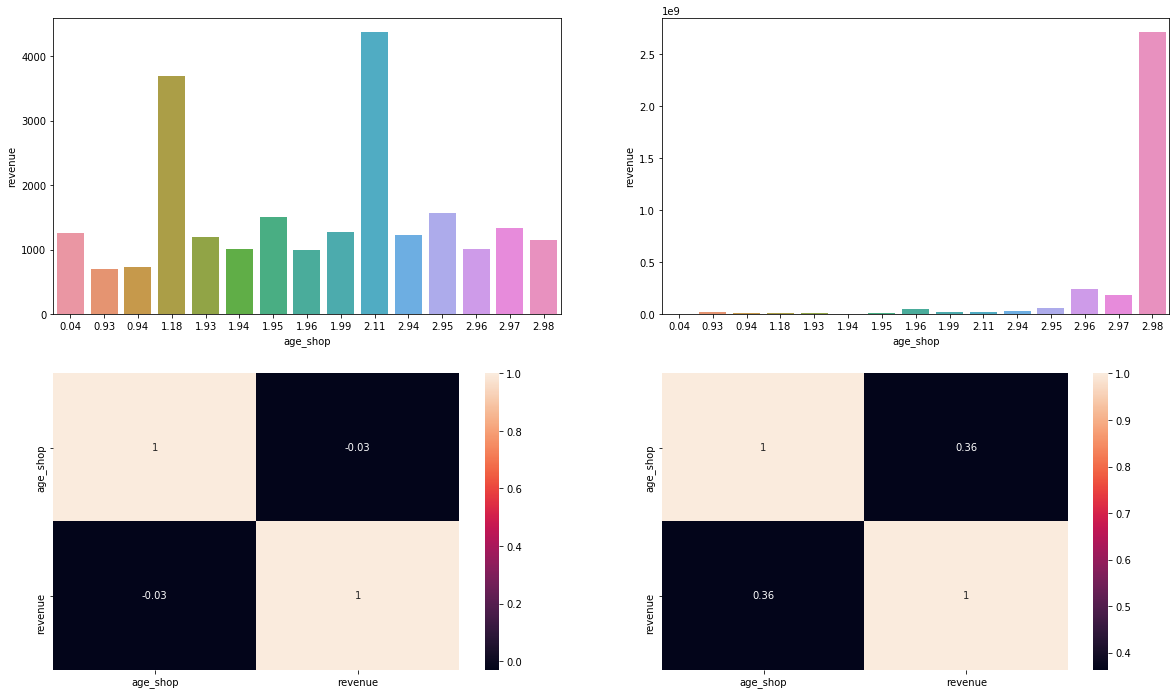

In [15]:
aux1 = df4[['age_shop','revenue']].groupby('age_shop').mean().reset_index()
aux2 = df4[['age_shop','revenue']].groupby('age_shop').sum().reset_index()

plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.barplot(x = 'age_shop',y = 'revenue', data = aux1);

plt.subplot(2,2,2)
sns.barplot(x = 'age_shop',y = 'revenue', data = aux2);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method= 'pearson'),annot = True);

plt.subplot(2,2,4)
sns.heatmap(aux2.corr(method= 'pearson'),annot = True);

### **7. Lojas em cidades Grandes Vendem mais**

**Verdadeiro** - É Verdadeiro quando visto com a soma, pois moscow e SPB (São petersburgo) são cidades grandes, quando vemos a média temos que ficam em torno do mesmo valor, menos as vendas por fora.

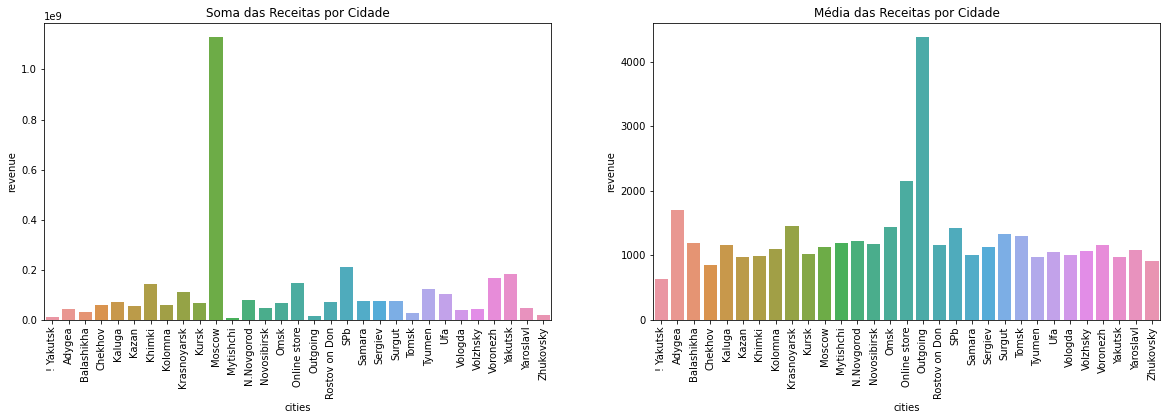

In [15]:
aux1 = df4[['cities','revenue']].groupby('cities').sum().reset_index()
aux2 = df4[['cities','revenue']].groupby('cities').mean().reset_index()

plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.barplot(x = 'cities',y = 'revenue', data = aux1);
plt.xticks(rotation = 90);
plt.title('Soma das Receitas por Cidade');

plt.subplot(2,2,2)
sns.barplot(x = 'cities',y = 'revenue', data = aux2);
plt.xticks(rotation = 90);
plt.title('Média das Receitas por Cidade');

## 4.3 Analise Multivariada

### 4.3 Numerical Attributes

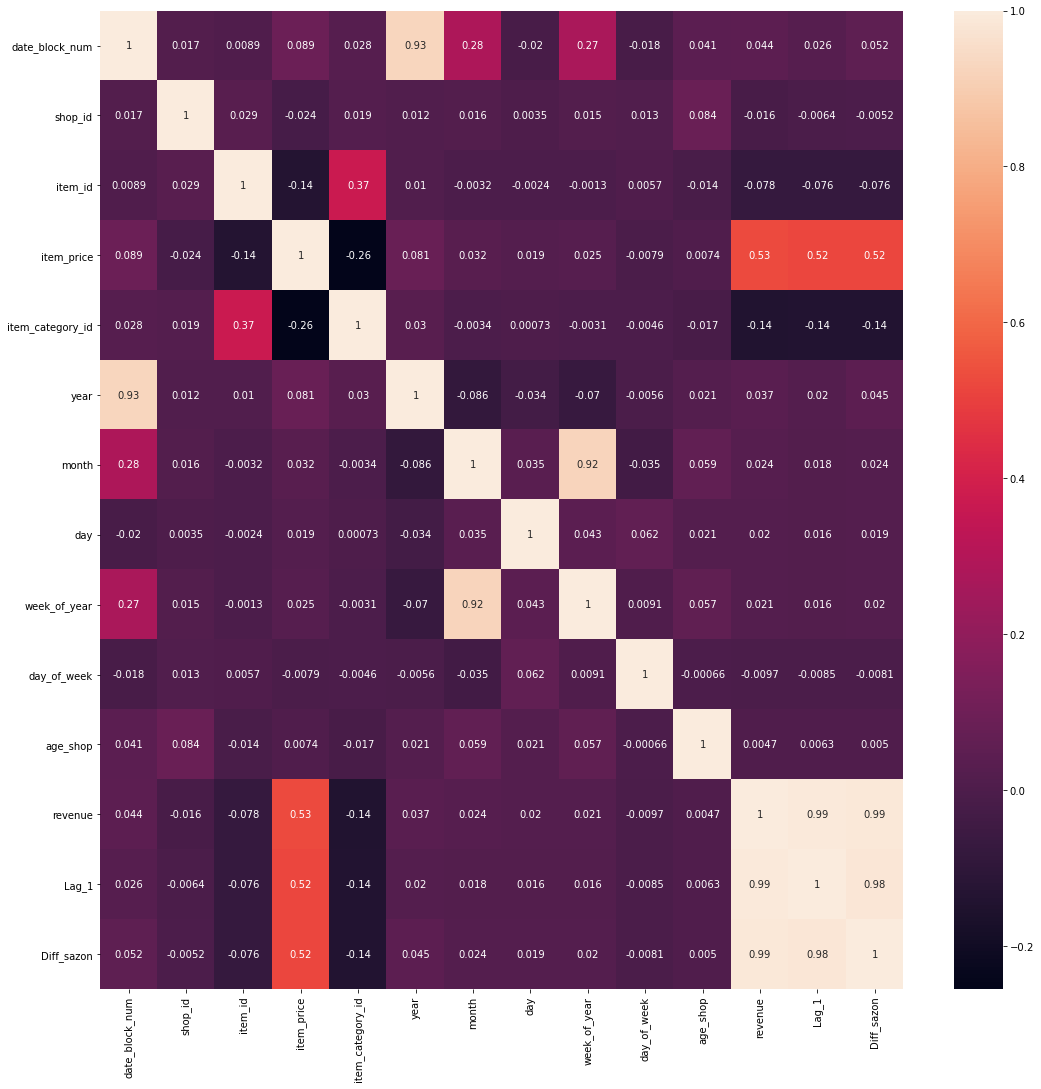

In [59]:
correlation = numerical_columns.corr(method = 'pearson')

plt.figure(figsize = (18,18))
sns.heatmap(correlation, annot = True)

# 5.0 Preparação dos Dados

Como vamos utilizar um modelo de machine learning, precisamos preparar nossos dados para um bom funcionamento do modelo. Vamos reescalar valores altos para ficar em um intervalo trabalhavel. Vamos transformar variaveis categoricas em numericos pois os modelos não entendem valores não numericos. Por fim valores ciclicos são necessarios tomar uma atenção diferentes pois como estamos trabalhando com valores que voltam para o inicio depois de um tempo.

In [7]:
df5 = df4.copy()
#df5 = df5.rename(columns = {'shop_name':'cities'})

## 5.1 Normalização

## 5.2 Rescaling

In [8]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler


rs = RobustScaler()
mms = MinMaxScaler()

df5['age_shop'] = rs.fit_transform(df5[['age_shop']].values)
#pickle.dump(rs, open('parameter/age_shop_scaler.pkl','wb'))


df5['year'] = mms.fit_transform(df5[['year']].values)
#pickle.dump(mms, open('parameter/year_scaler.pkl','wb'))

df5['date_block_num'] = mms.fit_transform(df5[['date_block_num']].values)
#pickle.dump(mms, open('parameter/date_block_num_scaler.pkl','wb'))


In [9]:
df5['Lag_1'] = mms.fit_transform(df5[['Lag_1']].values)

df5['Diff_sazon'] = mms.fit_transform(df5[['Diff_sazon']].values)

## 5.3 Transformação

### 5.3.1 Categorical Variables

In [10]:
#Transformação nas cidades
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df5['cities'] = le.fit_transform(df5['cities'])
#df5 = pd.get_dummies(df5, prefix = ['cities'], columns = ['cities'])

### 5.3.2 Response Variable Transformation

In [11]:
df5['revenue'] = np.log1p(df5['revenue'])

### 5.3.3 Nature Transformation

In [12]:
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))
#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

# 6.0 Seleção de variaveis

Na seleção de variavies vamos utilizar uma biblioteca chamada Boruta junto com o modelo de Random Forest para escolher as variaveis mais importantes para nosso modelo.

In [13]:
df6 = df5.copy()

## 6.1 Split DataFrame into training and test dataset

In [14]:
cols_drop = ['week_of_year','day_of_week','month','day','year_week']

df6 = df6.drop(cols_drop, axis = 1)

In [15]:
#training dataset
X_train = df6[df6['date'] < '2015-10-11']
y_train = X_train['revenue']

#test dataset
X_test = df6[df6['date'] >= '2015-10-11']
y_test = X_test['revenue']

In [16]:
print('Training Min Data:{}'.format(X_train['date'].min()))
print('Training Max Data:{}'.format(X_train['date'].max()))

print('Training Min Data:{}'.format(X_test['date'].min()))
print('Training Max Data:{}'.format(X_test['date'].max()))

Training Min Data:2013-01-01
Training Max Data:2015-10-10
Training Min Data:2015-10-13
Training Max Data:2015-12-10


## 6.2 Boruta as Feature Selector

In [17]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [18]:
#training and test dataset for Boruta
X_train_n = X_train.drop(['date','revenue'],axis = 1).values
y_train_n = y_train.values.ravel()
#define RandomFOrestRegressor
rf = RandomForestRegressor(n_jobs = -1)
#define Boruta
boruta = BorutaPy(rf,n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	5


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	5


In [19]:
cols_selects = boruta.support_.tolist()

X_train_fs = X_train.drop(['date','revenue'],axis =1)

cols_selected_boruta = X_train_fs.iloc[:,cols_selects].columns.to_list()

#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

In [20]:
cols_selected_boruta

['date_block_num',
 'shop_id',
 'item_id',
 'item_category_id',
 'age_shop',
 'Diff_sazon',
 'cities',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

## 6.3 Manual Feature Selection

In [17]:
cols_selected_boruta = [
'date_block_num',
 'shop_id',
 'item_id',
 'item_category_id',
 'age_shop',
 'Diff_sazon',
 'Lag_1',
 'cities',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

#columns to add
feat_to_add = ['date','revenue']

#final features
cols_selected_boruta_full = cols_selected_boruta
cols_selected_boruta_full.extend(feat_to_add)

In [ ]:
cols_selected_boruta_one = [
'date_block_num',
 'shop_id',
 'item_id',
 'item_category_id',
 'age_shop',
 'Diff_sazon',
 'cities_Tyumen',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 Modelos de Machine Learning

Inicialmente separamos nossos dados de treino e teste, vale ressaltar quando estamos trabalhando com series temporais não se pode separar aleatoriamente, é necessario fazer o corte em relação ao tempo, no nosso caso vamos separar nossos dados nas ultimas 6 semanas como dados de teste.

Foram feito comparação com 5 diferentes modelos, o primeiro deles é o mais basico, o modelo de média, só para ter uma noção de como os outros modelos estão se comportando, o segundo e o terceiro são modelos lineares tradicional e o modelo tradicional regularizado, respectivamente, o quarto modelo estamos utilizando XGBoost e por fim o modelo de Random Forest.

As metricas que utilizamos foram:
- MAE: O valor absoluto da media da diferença entre o valor real e o valor predito
- MAPE: É a porcentagem do valor absoluto da media da diferença entre o valor real e o valor predito
- RMSE: É a raiz quadrada da media da diferença entre o valor real e o valor predito

In [18]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]
x_training['date'] = pd.to_datetime(x_training['date'])

## 7.1 Average Model

In [18]:
aux1 = x_test.copy()
aux1['item_price'] = y_test.copy()

#Prediction
aux2 = aux1[['shop_id','item_price']].groupby('shop_id').mean().reset_index().rename(columns = {'item_price':'predictions'})

aux1 = pd.merge(aux1,aux2,how = 'left', on = 'shop_id')
yhat_baseline = aux1['predictions']

#performance
baseline_results = ml_error('Average Model', np.expm1(y_test),np.expm1(yhat_baseline))
baseline_results

,Model Name,MAE,MAPE,RMSE
0,Average Model,1052.638594,2.163951,3597.753999


## 7.2 Linear Regression Model

In [99]:
from sklearn.linear_model import LinearRegression,Lasso

In [98]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,765.629593,1.846701,27.670013


In [163]:
lr_result_cv = cross_val(x_training,5,'Linear Regression',lr,verbose = False)

In [164]:
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,763.167956,1.899323,27.625495


## 7.3 Linear Regression Regularized Model

In [105]:
#model
lrr = Lasso(alpha = 0.001).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,765.517536,1.834332,27.667988


In [165]:
lrr_result_cv = cross_val(x_training,5,'Linear Regression - Lasso',lrr,verbose = False)

In [166]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,707.16 +/- 48.46,2.12 +/- 0.52,26.58 +/- 0.92


## 7.4 Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [110]:
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,133.31078,0.12063,11.546029


In [167]:
rf_result_cv = cross_val(x_training,5,'Random Forest',rf,verbose = True)

Kfold Number: 5 

Kfold Number: 4 

Kfold Number: 3 

Kfold Number: 2 

Kfold Number: 1 



In [168]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,116.71 +/- 10.41,0.22 +/- 0.11,10.79 +/- 0.47


## 7.5 XGBoost Regressor

In [112]:
import xgboost as xgb

In [114]:
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators = 100, eta =0.01,
                            max_depth = 10, 
                            subsample = 0.7,
                            colsample_bytree =0.9,
                            random_state = 42).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XgBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XgBoost Regressor,1040.509768,0.867751,32.256934


In [169]:
#xgb_result_cv = cross_val(x_training,5,'XGBoost Regressor',model_xgb,verbose = True)

Kfold Number: 5 

Kfold Number: 4 

Kfold Number: 3 

Kfold Number: 2 

Kfold Number: 1 



In [170]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,969.09 +/- 55.71,0.96 +/- 0.13,31.12 +/- 0.9


## 7.6 Compare Model's Performance

In [174]:
#modelling_result = pd.concat([baseline_results,lr_result,lrr_result,rf_result,xgb_result])
#modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,133.310780,0.120630,11.546029
0,Linear Regression,763.167956,1.899323,27.625495
0,Linear Regression - Lasso,765.517536,1.834332,27.667988
0,Average Model,833.404166,2.867253,28.868740
0,XgBoost Regressor,1040.509768,0.867751,32.256934


In [173]:
#real_modelling_result= pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
#real_modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,116.71 +/- 10.41,0.22 +/- 0.11,10.79 +/- 0.47
0,Linear Regression,707.14 +/- 48.32,2.14 +/- 0.52,26.58 +/- 0.91
0,Linear Regression - Lasso,707.16 +/- 48.46,2.12 +/- 0.52,26.58 +/- 0.92
0,XGBoost Regressor,969.09 +/- 55.71,0.96 +/- 0.13,31.12 +/- 0.9


# 8.0 Hyperparameter Fine Tuning


O modelo de Random Forest foi que deu o valor mais baixos entres as avaliações, por isso vamos utiliza-lo, agora precisamos encontrar os melhores paraemtros que se encaixam no nosso problema, vamos utilizar a metodologia do Random Search, onde passas um conjunto de valores para cada parametro e aleatoriamente o nosso algoritmo sorteia e ve quais são as suas metricas,e no final pegamos a menor delas. No fim encontramos os seguintes parametros:
- **n_estimators = 350**
- **max_depth = 60**
- **max_features = 'auto'**
- **min_samples_leaf = 3**
- **min_samples_split =5**

Simulei tambem para ver os resultados de XGBoost, porém os resultados foram superiores

## 8.1 Random Search

In [19]:
import random
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

## 8.1.1 XGBoost Final Parameters

In [25]:
param = {
        'n_estimators':[150,170,250,300,350],
        'eta':[0.01,0.1,0.3],
        'max_depth':[3,5,9,11],
        'subsample':[0.1,0.5,0.7],
        'colsample_bytree':[0.3,0.7,0.9],
        'min_child_weight':[3,8,15]
        }
MAX_EVAL = 5

In [26]:
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
    ##choose values for parameters randomly
    hp = {k : random.sample(v,1)[0] for k , v in param.items() }
    print(hp)
    #model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators = hp['n_estimators'], 
                             eta = hp['eta'],
                            max_depth = hp['max_depth'], 
                            subsample = hp['subsample'],
                            colsample_bytree = hp['colsample_bytree'],
                            min_child_weight = hp['min_child_weight'],
                            random_state = 42)
    #performance
    result =  cross_val(x_training, 3, 'XgBoost Regressor',model_xgb, verbose = False)
    final_result = pd.concat([final_result,result])
    
final_result

{'n_estimators': 350, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 350, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 250, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 350, 'eta': 0.01, 'max_depth': 11, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 300, 'eta': 0.1, 'max_depth': 11, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XgBoost Regressor,131.36 +/- 16.57,0.36 +/- 0.13,492.67 +/- 201.82
0,XgBoost Regressor,135.65 +/- 21.47,0.27 +/- 0.05,470.33 +/- 214.94
0,XgBoost Regressor,148.03 +/- 22.62,0.39 +/- 0.13,607.29 +/- 256.85
0,XgBoost Regressor,307.18 +/- 66.37,0.39 +/- 0.09,1366.27 +/- 615.62
0,XgBoost Regressor,113.02 +/- 14.71,0.27 +/- 0.06,354.46 +/- 124.04


In [27]:
param_tuned = {
        'n_estimators':300,
        'eta':0.1,
        'max_depth': 11,
        'subsample': 0.5,
        'colsample_bytree': 0.9,
        'min_child_weight':8
        }

model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators = param_tuned['n_estimators'], 
                             eta = param_tuned['eta'],
                            max_depth = param_tuned['max_depth'], 
                            subsample = param_tuned['subsample'],
                            colsample_bytree = param_tuned['colsample_bytree'],
                            min_child_weight = param_tuned['min_child_weight'],
                            random_state = 42).fit(x_train.drop(['date','revenue'],axis =1),y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test.drop(['date','revenue'],axis =1))

#performance
xgb_result = ml_error('XgBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XgBoost Regressor,132.749633,0.195521,415.208401


## 8.1.2 Random Forest

In [21]:
param = {
        'n_estimators':[150,170,250,300,350],
        'max_features':['auto','sqrt','log2'],
        'max_depth':[10,20,30,40,50,60],
        'min_samples_leaf': [1, 2, 5,10,15],
        'min_samples_split': [2, 5, 10]
        }
MAX_EVAL = 5

In [22]:
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
    ##choose values for parameters randomly
    hp = {k : random.sample(v,1)[0] for k , v in param.items() }
    print(hp)
    #model
    model_rf = RandomForestRegressor(n_estimators = hp['n_estimators'], 
                             max_features = hp['max_features'],
                            max_depth = hp['max_depth'], 
                            min_samples_leaf = hp['min_samples_leaf'],
                            min_samples_split = hp['min_samples_split'],
                            n_jobs = -1,
                            random_state = 42)
    #performance
    result =  cross_val(x_training, 3, 'Random Forest',model_rf, verbose = False)
    final_result = pd.concat([final_result,result])
    
final_result

{'n_estimators': 170, 'max_features': 'log2', 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 10}
{'n_estimators': 350, 'max_features': 'auto', 'max_depth': 60, 'min_samples_leaf': 10, 'min_samples_split': 2}
{'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5}
{'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 2}
{'n_estimators': 250, 'max_features': 'log2', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,165.07 +/- 57.53,0.3 +/- 0.08,1977.59 +/- 1161.65
0,Random Forest,84.63 +/- 4.68,0.24 +/- 0.08,160.45 +/- 17.54
0,Random Forest,172.94 +/- 57.98,0.34 +/- 0.1,2017.72 +/- 1146.06
0,Random Forest,180.85 +/- 63.6,0.33 +/- 0.1,2111.35 +/- 1196.81
0,Random Forest,169.57 +/- 58.76,0.32 +/- 0.08,1979.69 +/- 1170.32


In [19]:
rf = RandomForestRegressor(n_estimators = 350, 
                           max_depth = 60,
                           max_features = 'auto',
                           min_samples_leaf = 3,
                           min_samples_split =5,
                           n_jobs = -1, 
                           random_state = 42).fit(x_train.drop(['date','revenue'],axis =1), y_train)

#prediction
yhat_rf = rf.predict(x_test.drop(['date','revenue'],axis =1))

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,75.677146,0.169418,121.931914


# 9.0 Traducao e Interpretação do Erro

Com o modelo otimizado, podemos gerar nossos valores preditivios e fazer a comparação com o seu valor real. Primeiro fizemos uma tabela só com as prediçôes, tendo o melhor e o pior cenarios (utilizamos o MAE para somar e subtrair), podemos agregar em um valor final ou separar por lojas, o mais adequado. E por fim fizemos alguns graficos para ver como o erro e a taxa do erro esta relacionado com a predição.

In [20]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['revenue'] = np.expm1(df9['revenue'])
df9['predictions'] = np.expm1(yhat_rf)

## 9.1 Bussiness Performace

In [21]:
# sum of predictions

df91 = df9[['shop_id','predictions']].groupby('shop_id').sum().reset_index()

# MAE and MAPE
df9aux1 = df9[['shop_id','revenue','predictions']].groupby('shop_id').apply(lambda x: mean_absolute_error(x['revenue'],x['predictions'])).reset_index().rename(columns = {0:'MAE'} )
df9aux2 = df9[['shop_id','revenue','predictions']].groupby('shop_id').apply(lambda x: mean_absolute_percentage_error(x['revenue'],x['predictions'])).reset_index().rename(columns = {0:'MAPE'} )

#Merge
df9aux3 = pd.merge(df9aux1,df9aux2,how = 'inner',on = 'shop_id')
df92 = pd.merge(df91,df9aux3,how = 'inner',on = 'shop_id')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['shop_id','predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [22]:
df92.sort_values('MAPE', ascending = False).head()

,shop_id,predictions,worst_scenario,best_scenario,MAE,MAPE
12,17,102057.666715,101879.473476,102235.859955,178.193239,1.893125
35,43,151159.412045,151045.757064,151273.067026,113.654981,1.436819
25,33,160194.613961,159996.645608,160392.582314,197.968353,0.647101
28,36,424121.213928,423952.271494,424290.156362,168.942434,0.645887
26,34,701974.561646,701780.428848,702168.694443,194.132798,0.495751


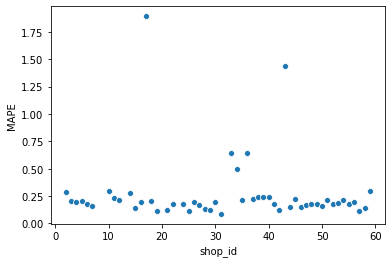

In [23]:
sns.scatterplot(x = 'shop_id',y = 'MAPE', data = df92);

## 9.2 Total Performance

In [24]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename( columns = {'index':'Scenarios',0: 'Values'})

df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$94,788,041.64"
1,worst_scenario,"R$94,783,125.41"
2,best_scenario,"R$94,792,957.87"


## 9.3 Machine Learning Performance

In [25]:
df9['error'] = df9['revenue'] - df9['predictions']
df9['error_rate'] =  df9['predictions']/df9['revenue']

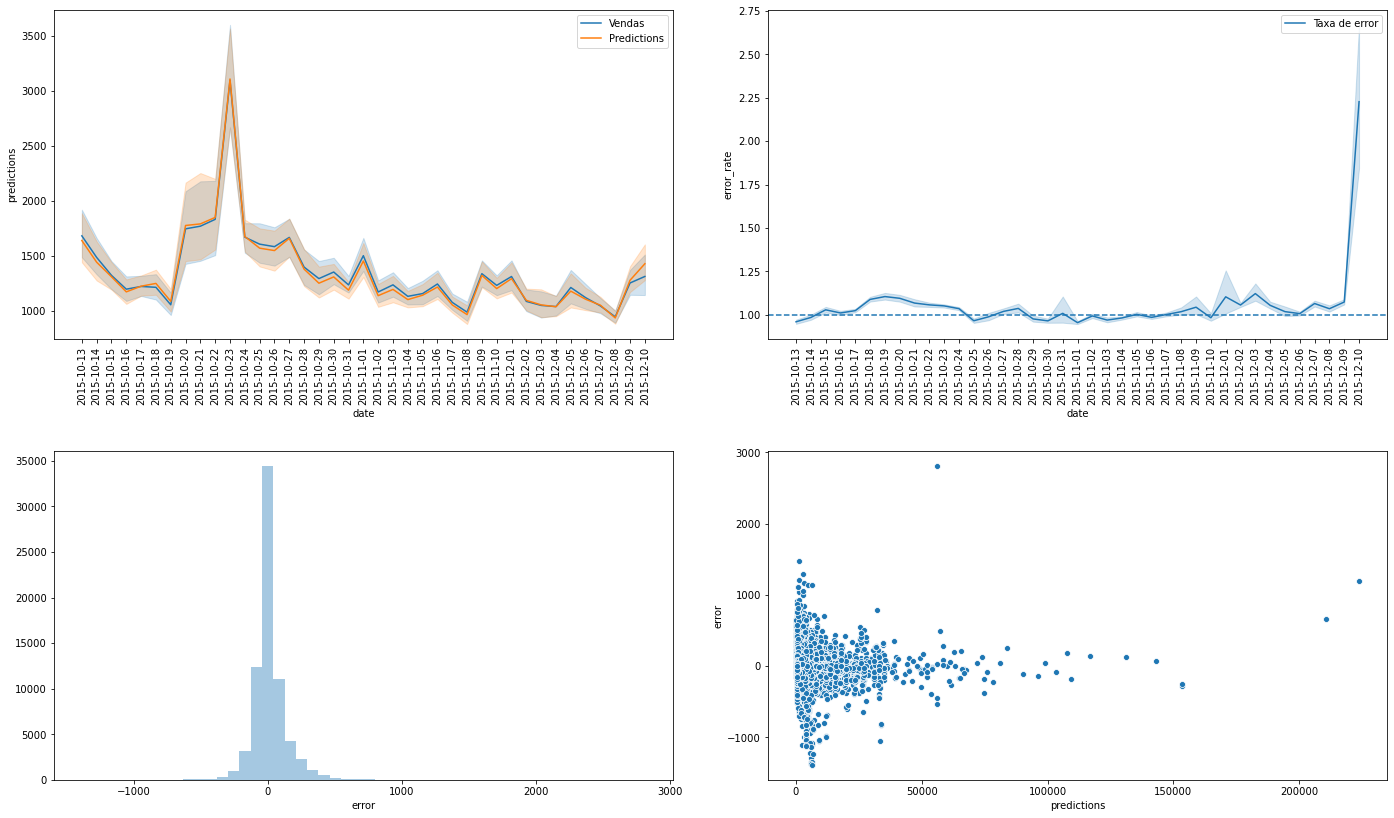

In [26]:
plt.figure(figsize = (20,12))
plt.subplot(2,2,1)

sns.lineplot(x = 'date', y= 'revenue', data = df9, label='Vendas')
sns.lineplot(x = 'date', y= 'predictions', data = df9, label='Predictions')

plt.xticks(rotation = 90);

plt.subplot(2,2,2)

sns.lineplot(x = 'date', y= 'error_rate', data = df9, label='Taxa de error')
plt.axhline(1,linestyle = '--')
plt.xticks(rotation = 90);

plt.subplot(2,2,3)
sns.distplot(df9['error'], kde = False)

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

plt.tight_layout(pad=3.0)

# 10.0 Conclusão

Pelos resultados obtidos utilizando Random Forest tivemos que o lucro da empresa vai ser em torno de 94 milhões de reais, ainda mostramos o intervalo que isso dos valores. O modelo desempenhou bem, notamos que em algumas lojas tem espaço para melhorar a performace do MAPE, mas no geral é um modelo bom para fazer previsões. Entretanto podemos ainda realizar alguns processamento nessa base de dados.

Conseguimos notar que a curva dos valores preditos conseguiu aprender bem a sazonalinadade, porém quando vimos a taxa do erro nos ultimos três dias temos que o nosso modelo não responde bem, pode estar relacionado por não estar completo o mês ou para esse periodo não temos dados suficientes.

Podemos implementar modelos proprios para fazer previsões em series temporais como ARIMA ou ARIMAX, para fazer a comparação e ver a performace dos modelos.